In [211]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib import colors
from matplotlib.colors import LogNorm

%matplotlib inline
from scipy.optimize import curve_fit, minimize
import strax
import straxbra

In [212]:
ctx = straxbra.XebraContext()
run = '00186'
# peaks_data_xebra = ctx.get_array(run, 'peaks')
# ncomp = ctx.get_array(run, 'n_competing')
event_basics = ctx.get_array(run, 'event_basics')
# records_data = ctx.get_array(run, 'records')
# raw_records_data = ctx.get_array(run, 'raw_records')
# ctx.data_info('peaks')
# ctx.data_info('n_competing')
# ctx.data_info('event_basics')

In [213]:
# ctx.data_info('n_competing')

In [214]:
# ctx.data_info('event_basics')

In [215]:
# ctx.data_info('records')

In [216]:
S1_area = event_basics['s1_area']
S2_area = event_basics['s2_area']

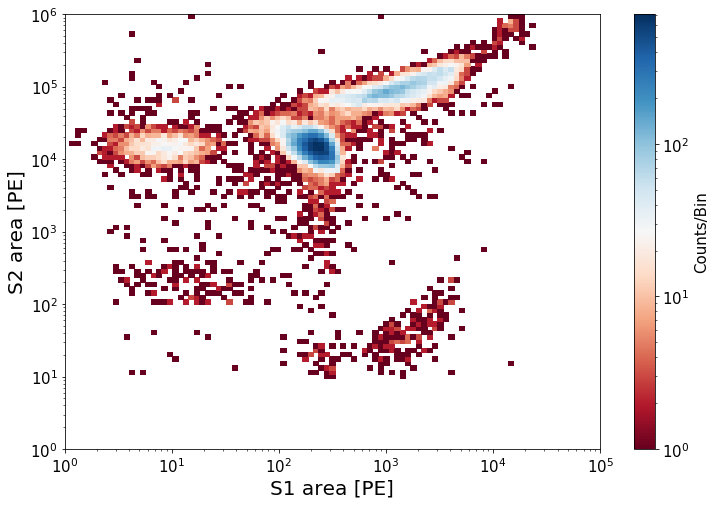

In [217]:
fig, ax = plt.subplots(figsize=(12,8))

bins_x = np.logspace(0,5,100)
bins_y = np.logspace(0,6,100)
histo_max= 2*10**3

counts, _, _ = np.histogram2d(S1_area, S2_area, bins=(bins_x, bins_y))

im = ax.pcolormesh(bins_x, bins_y, counts.T, cmap='RdBu', norm=mcolors.LogNorm())
ax.set_xlabel('S1 area [PE]', fontsize = 20)
ax.set_ylabel('S2 area [PE]', fontsize = 20)

#ax.set_title(' xxx', fontsize= 15)
ax.tick_params(axis='both', which='major', labelsize=15)

ax.set_xscale('log')
ax.set_yscale('log')
cbar = plt.colorbar(im, ax=ax)
cbar.ax.tick_params(labelsize=15)
cbar.set_label(label ='Counts/Bin', fontsize=15)

In [218]:
# plt.figure(figsize=(18,13))
# plt.hist(ncomp['n_competing'], bins=np.arange(20))
# plt.show()

[34.32 14.58 11.76 ... 26.48  8.15 32.6 ]


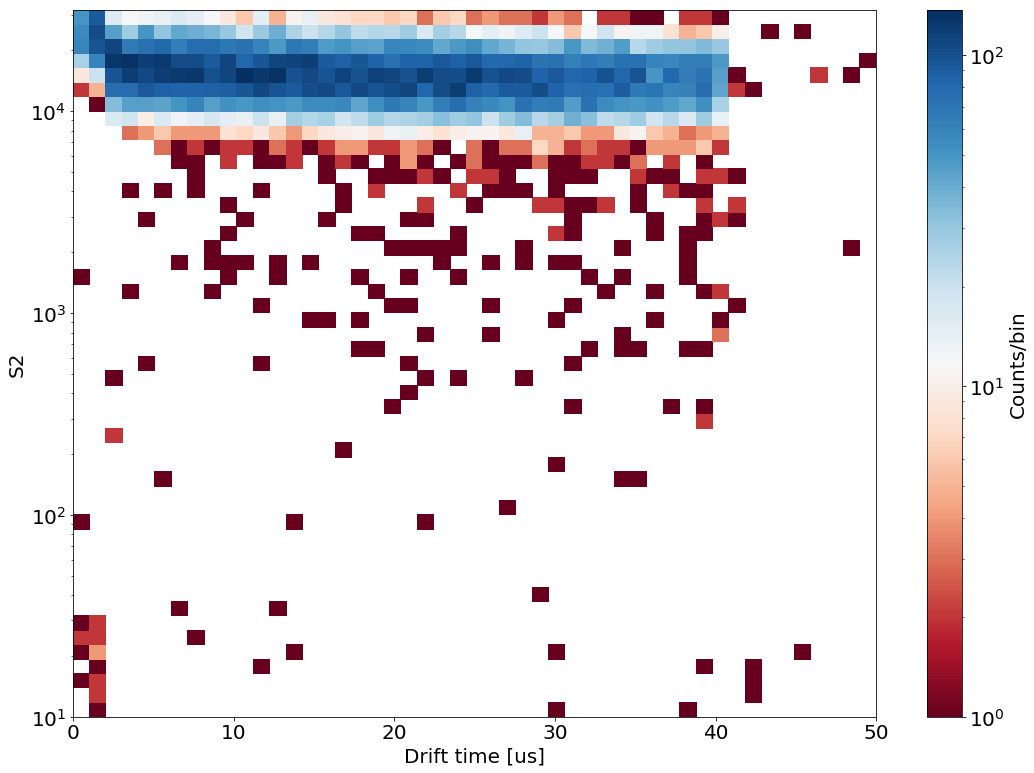

In [219]:
line = event_basics[(100<event_basics['s1_area']) & (event_basics['s1_area'] < 300)]
fig, ax = plt.subplots(figsize=(18,13))

bins_x = np.linspace(0,50,50)
bins_y = np.logspace(1,4.5,50)
counts, xedges, yedges = np.histogram2d(line['drift_time']/1e3, line['s2_area'], bins=(bins_x, bins_y))
print(line['drift_time']/1e3)
im = ax.pcolormesh(bins_x, bins_y, counts.T, norm=LogNorm(), cmap = 'RdBu')
plt.colorbar(im,ax=ax, label='Counts/bin')
ax.set_yscale('log')

ax.set_xlabel('Drift time [us]')
ax.set_ylabel('S2')
plt.show()

In [220]:
xcenter = ((xedges[:-1]+xedges[1:])/2)
ycenter = ((yedges[:-1]+yedges[1:])/2)
# print(xcenter)
# print(ycenter)

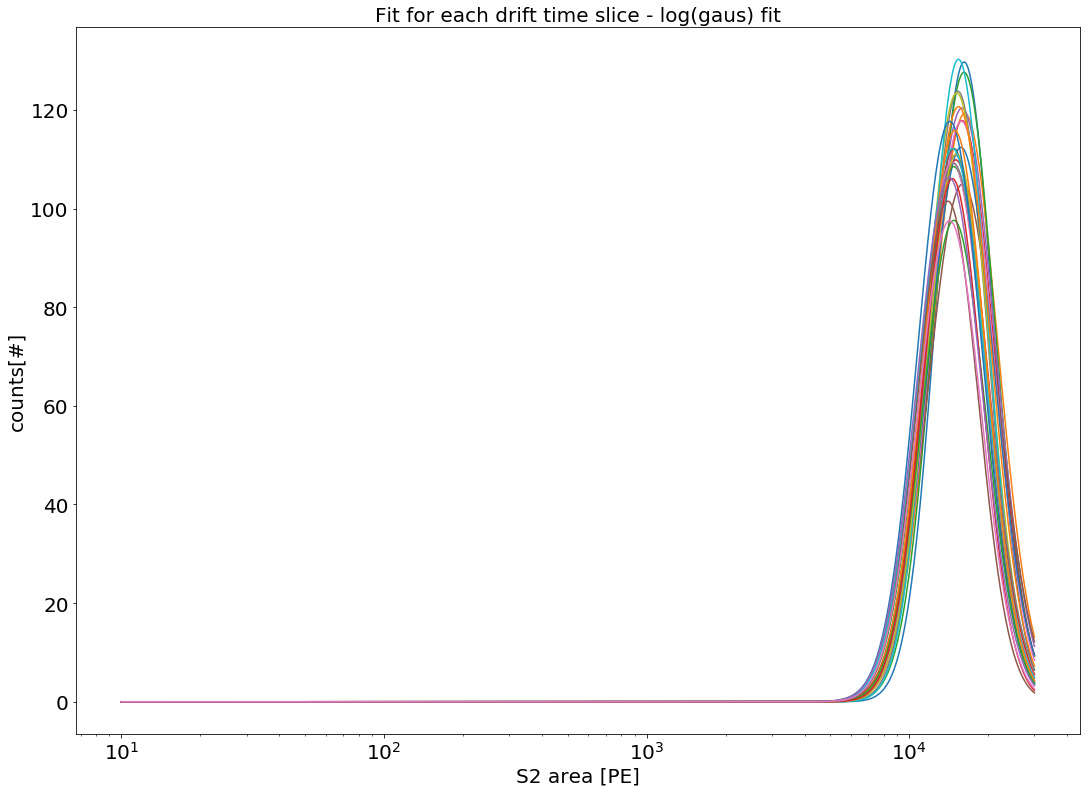

In [221]:
fig, ax = plt.subplots(figsize=(18,13))
fit_range= np.linspace(10,30000,1000)

def single_gaus(x, h, mu, sigma):

    gaus = h * np.exp(-(np.log(x)-mu)**2         /(2*sigma**2))
    return gaus
p0 = [60,8,8]
mu_list = []
mu_error_list = []
# popt, pcov = curve_fit(single_gaus, ycenter, counts[27], p0)
# plt.scatter(ycenter, counts[27], c = 'r', marker = 'x')
# plt.plot(fit_range, single_gaus(fit_range, *popt))
ax.set_xscale('log')
ax.set_title('Fit for each drift time slice - log(gaus) fit', fontsize = 20)
ax.set_xlabel('S2 area [PE]', fontsize = 20)
ax.set_ylabel('counts[#]', fontsize = 20)
for i in range(3,30):   
    popt, pcov = curve_fit(single_gaus, ycenter, counts[i], p0)
    plt.plot(fit_range, single_gaus(fit_range, *popt))
    #value = np.exp(popt[1])
    value = np.exp(popt[1]+((popt[2]**2)/2))
    mu_list.append(value)
    perr = np.sqrt(np.diag(pcov))
    error_ln_mu = perr[1]
    error_mu = np.exp(popt[1])*error_ln_mu
    mu_error_list.append(error_mu)


plt.show()




In [222]:
print(counts[30])


[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  1.  0.  0.  1.  0.  0.  0.  1.  0.  0.  1.  0.  1.  1.  1.
  0.  1.  1.  2.  6. 38. 46. 75. 83. 63. 49.  6.  3.]


this is lamba:  0.004853002694207134
this is 1/lamba:  206.0579939907444
electron lifetime:  206.06 +/- 165.07


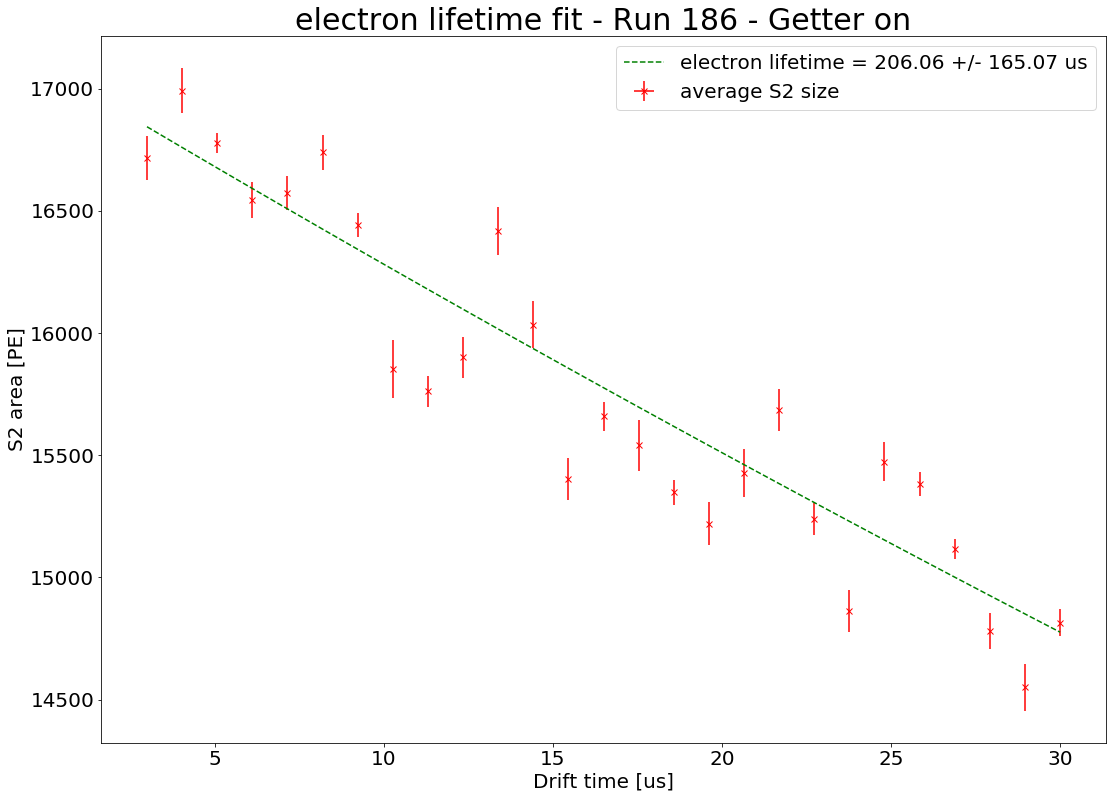

In [223]:
def expo(x, a, b):
    return a*np.exp(-b*x)

fig, ax =plt.subplots(figsize = (18,13))
p0=  [10000,0.1]
x = np.linspace(3,30,27)
y_values = mu_list
y_error = mu_error_list
SIZE = 20
EXTRA_SIZE = 30

plt.rc('font', size=SIZE)          # controls default text sizes
plt.rc('axes', titlesize=EXTRA_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SIZE)    # legend fontsize
plt.rc('figure', titlesize=SIZE)

popt, pcov = curve_fit(expo, x, y_values, sigma=y_error, p0=p0, absolute_sigma=True, maxfev= 10000)
# lifetime = 1/popt[1]
# lifetime_error = (1/(popt[1]**2))*perr[1]
lifetime = "%.2f" % (1/popt[1])
lifetime_error = "%.2f" % ((1/(popt[1]**2))*perr[1])

plt.errorbar(x, y_values, yerr=y_error, xerr=0, fmt = 'rx', label = 'average S2 size' )

print('this is lamba: ', popt[1])
print('this is 1/lamba: ', 1/popt[1] )
plt.plot(x, expo(x, *popt), 'g--', label = 'electron lifetime = '+str(lifetime)+ ' +/- '+str(lifetime_error)+' us')
# print(y_error)


#ax.set_ylim([130,250])
ax.set_title('electron lifetime fit - Run '+run[2:]+' - Getter on')
ax.set_xlabel('Drift time [us]')
ax.set_ylabel('S2 area [PE]')


print('electron lifetime: ', lifetime, '+/-', lifetime_error)
# print(perr)
plt.legend(prop={'size': 20})
plt.show()

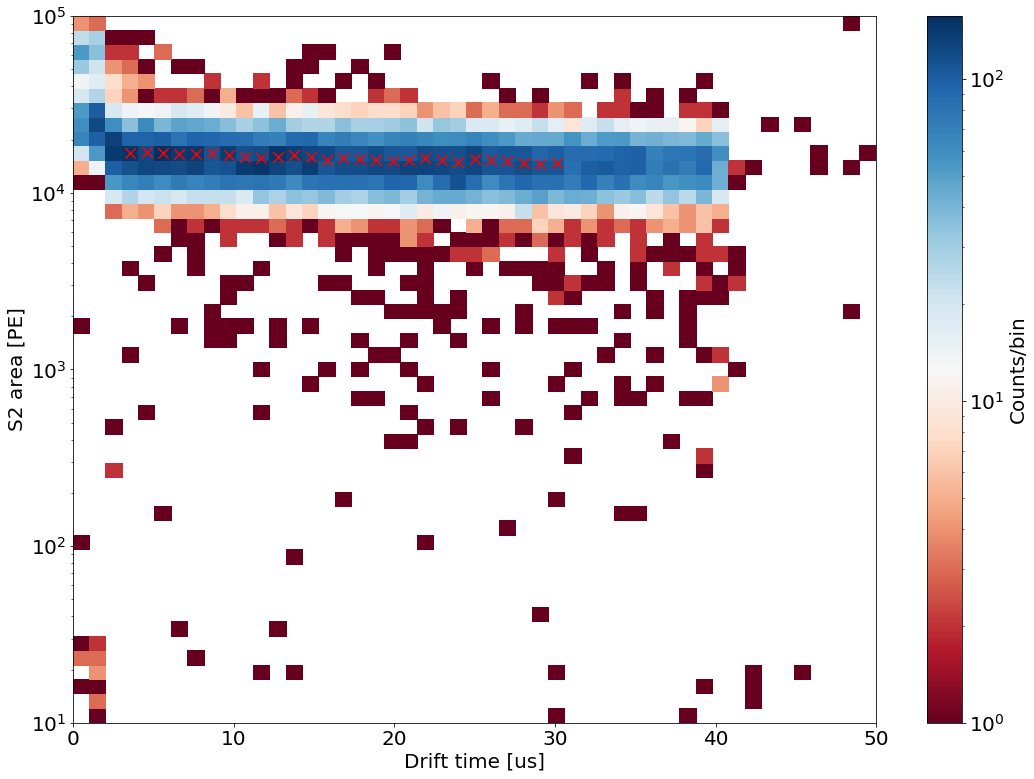

In [224]:
line = event_basics[(100<event_basics['s1_area']) & (event_basics['s1_area'] < 300)]
fig, ax = plt.subplots(figsize=(18,13))

bins_x = np.linspace(0,50,50)
bins_y = np.logspace(1,5,50)
counts, xedges, yedges = np.histogram2d(line['drift_time']/1e3, line['s2_area'], bins=(bins_x, bins_y))

im = ax.pcolormesh(bins_x, bins_y, counts.T, norm=LogNorm(), cmap = 'RdBu')
plt.colorbar(im,ax=ax, label='Counts/bin')

plt.scatter(xcenter[3:30], y_values, c = 'r', marker = 'x', s =110)

ax.set_yscale('log')

ax.set_xlabel('Drift time [us]')
ax.set_ylabel('S2 area [PE]')
plt.show()

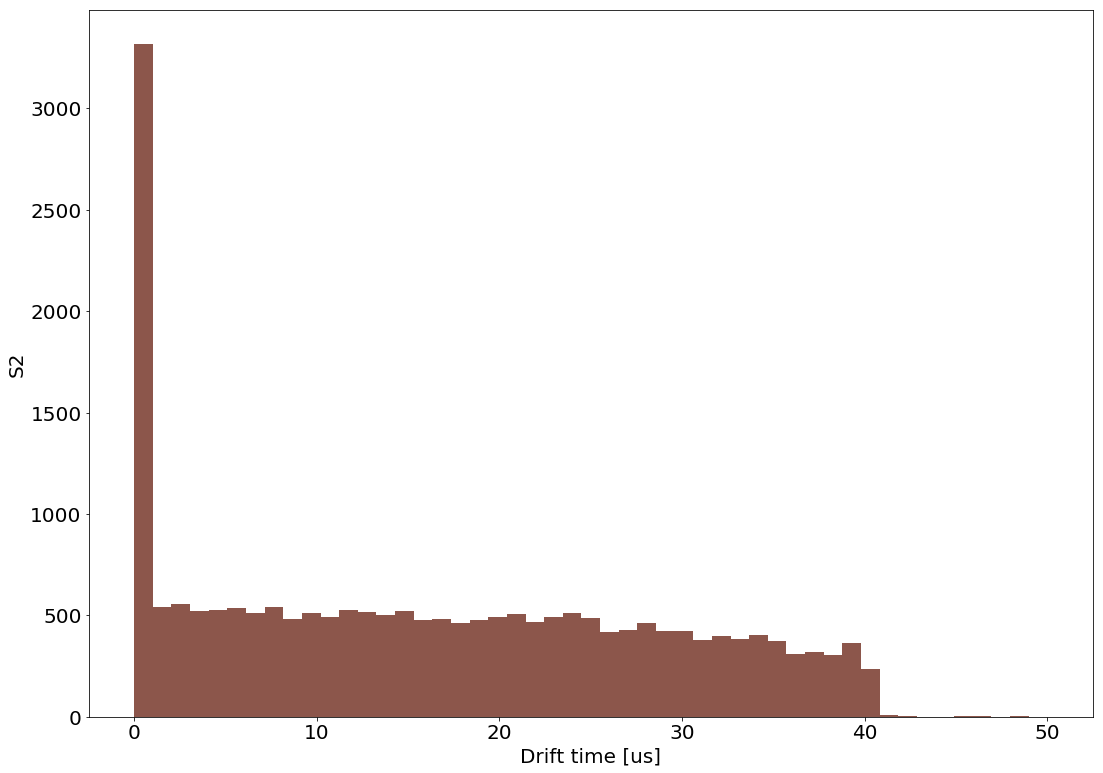

In [225]:
line = event_basics[(100<event_basics['s1_area']) & (event_basics['s1_area'] < 300)]
fig, ax = plt.subplots(figsize=(18,13))

bins_x = np.linspace(0,50,50)
#bins_y = np.logspace(1,3.5,50)
counts, binEdges = np.histogram(line['drift_time']/1e3, bins=bins_x)

#ax.set_yscale('log')
plt.hist(line['drift_time']/1e3, bins=bins_x, color='C5')
ax.set_xlabel('Drift time [us]')
ax.set_ylabel('S2')
plt.show()

In [226]:
eval('1'+'+2')

3

In [227]:
# import numpy as np
# import matplotlib as mpl
# import matplotlib.pyplot as plt
# import matplotlib.colors as mcolors
# from matplotlib import colors
# from matplotlib.colors import LogNorm

# %matplotlib inline
# from scipy.optimize import curve_fit, minimize
# import strax
# import straxbra

In [228]:
# ctx = straxbra.XebraContext()

In [229]:



# run_list = ['00245''00246','00247','00248', '00249', '00250']



# Lifetime_list = []
# Lifetime_error_list = []

# for run in run_list:
#     event_basics = ctx.get_array(run, 'event_basics')
#     S1_area = event_basics['s1_area']
#     S2_area = event_basics['s2_area']

#     fig, ax = plt.subplots(figsize=(12,8))
#     bins_x = np.logspace(0,5,100)
#     bins_y = np.logspace(0,6,100)
#     histo_max= 2*10**3

#     counts, _, _ = np.histogram2d(S1_area, S2_area, bins=(bins_x, bins_y))
#     im = ax.pcolormesh(bins_x, bins_y, counts.T, cmap='RdBu', norm=mcolors.LogNorm())
#     ax.set_xlabel('S1 area [PE]', fontsize = 20)
#     ax.set_ylabel('S2 area [PE]', fontsize = 20)
#     ax.tick_params(axis='both', which='major', labelsize=15)
#     ax.set_xscale('log')
#     ax.set_yscale('log')
#     cbar = plt.colorbar(im, ax=ax)
#     cbar.ax.tick_params(labelsize=15)
#     cbar.set_label(label ='Counts/Bin', fontsize=15)  
    
#     line = event_basics[(100<event_basics['s1_area']) & (event_basics['s1_area'] < 300)]
#     fig, ax = plt.subplots(figsize=(18,13))
#     bins_x = np.linspace(0,50,50)
#     bins_y = np.logspace(1,4.5,50)
#     counts, xedges, yedges = np.histogram2d(line['drift_time']/1e3, line['s2_area'], bins=(bins_x, bins_y))
#     print(line['drift_time']/1e3)
#     im = ax.pcolormesh(bins_x, bins_y, counts.T, norm=LogNorm(), cmap = 'RdBu')
#     plt.colorbar(im,ax=ax, label='Counts/bin')
#     ax.set_yscale('log')
#     ax.set_xlabel('Drift time [us]')
#     ax.set_ylabel('S2')
    
#     xcenter = ((xedges[:-1]+xedges[1:])/2)
#     ycenter = ((yedges[:-1]+yedges[1:])/2)
    
#     fig, ax = plt.subplots(figsize=(18,13))
#     fit_range= np.linspace(10,30000,1000)

#     def single_gaus(x, h, mu, sigma):

#         gaus = h * np.exp(-(np.log(x)-mu)**2         /(2*sigma**2))
#         return gaus
#     p0 = [60,8,8]
#     mu_list = []
#     mu_error_list = []
#     # popt, pcov = curve_fit(single_gaus, ycenter, counts[27], p0)
#     # plt.scatter(ycenter, counts[27], c = 'r', marker = 'x')
#     # plt.plot(fit_range, single_gaus(fit_range, *popt))
#     ax.set_xscale('log')
#     ax.set_title('Fit for each drift time slice - log(gaus) fit', fontsize = 20)
#     ax.set_xlabel('S2 area [PE]', fontsize = 20)
#     ax.set_ylabel('counts[#]', fontsize = 20)
#     for i in range(3,30):   
#         popt, pcov = curve_fit(single_gaus, ycenter, counts[i], p0)
#         plt.plot(fit_range, single_gaus(fit_range, *popt))
#         #value = np.exp(popt[1])
#         value = np.exp(popt[1]+((popt[2]**2)/2))
#         mu_list.append(value)
#         perr = np.sqrt(np.diag(pcov))
#         error_ln_mu = perr[1]
#         error_mu = np.exp(popt[1])*error_ln_mu
#         mu_error_list.append(error_mu)


#     def expo(x, a, b):
#         return a*np.exp(-b*x)

#     fig, ax =plt.subplots(figsize = (18,13))
#     p0=  [10000,0.1]
#     x = np.linspace(3,30,27)
#     y_values = mu_list
#     y_error = mu_error_list

#     SIZE = 20
#     EXTRA_SIZE = 30

#     plt.rc('font', size=SIZE)          # controls default text sizes
#     plt.rc('axes', titlesize=EXTRA_SIZE)     # fontsize of the axes title
#     plt.rc('axes', labelsize=SIZE)    # fontsize of the x and y labels
#     plt.rc('xtick', labelsize=SIZE)    # fontsize of the tick labels
#     plt.rc('ytick', labelsize=SIZE)    # fontsize of the tick labels
#     plt.rc('legend', fontsize=SIZE)    # legend fontsize
#     plt.rc('figure', titlesize=SIZE)
    
#     popt, pcov = curve_fit(expo, x, y_values, sigma=y_error, p0=p0, absolute_sigma=True, maxfev= 10000)
#     # lifetime = 1/popt[1]
#     # lifetime_error = (1/(popt[1]**2))*perr[1]
#     lifetime = "%.2f" % (1/popt[1]*np.log(2))
#     lifetime_error = "%.2f" % ((1/(popt[1]**2))*perr[1])

#     plt.errorbar(x, y_values, yerr=y_error, xerr=0, fmt = 'rx', label = 'average S2 size' )

#     print('this is lamba: ', popt[1])
#     print('this is 1/lamba: ', 1/popt[1] )
#     plt.plot(x, expo(x, *popt), 'g--', label = 'electron lifetime = '+str(lifetime)+ ' +/- '+str(lifetime_error)+' us')
    
#     # print(y_error)


#     #ax.set_ylim([130,250])
#     ax.set_title('electron lifetime fit - Run 226 - Getter off')
#     ax.set_xlabel('Drift time [us]')
#     ax.set_ylabel('S2 area [PE]')


#     print('electron lifetime: ', lifetime, '+/-', lifetime_error)
#     # print(perr)
#     plt.legend(prop={'size': 20})
#     Lifetime_list.append(lifetime)
#     Lifetime_error_list.append(lifetime_error)
#     plt.show()




In [230]:
# print(Lifetime_list)
# print(Lifetime_error_list)

In [231]:
Lifetime_all = ['6.66', '6.35', '6.62', '7.42', '8.77', '10.01', '11.56', '13.67', '15.91', '18.41', '20.63', '23.55', '26.11', '29.72', '32.51', '34.77', '40.29', '40.81', '42.18', '44.72', '47.32', '51.11', '51.64', '55.86', '53.91']
Lifetime_error_all = ['2.50', '1.63', '1.90', '2.26', '1.78', '1.82', '2.63', '2.62', '5.17', '4.85', '8.14', '5.48', '8.54', '9.57', '10.60', '17.11', '11.62', '31.69', '37.76', '12.10', '20.64', '20.01', '18.05', '47.35', '39.50']

Electron_lifetime_list = [float(i) for i in Lifetime_all] * 1/(np.log(2))
Electron_lifetime_error_list = [float(j) for j in Lifetime_error_all]
Time = [0,30,60,90,120,150,180,210,240,270,300,330,360,390,420,450,480,510,540,570,600,630,660,690,720]


this is lamba:  0.004853002694207134
this is 1/lamba:  206.0579939907444


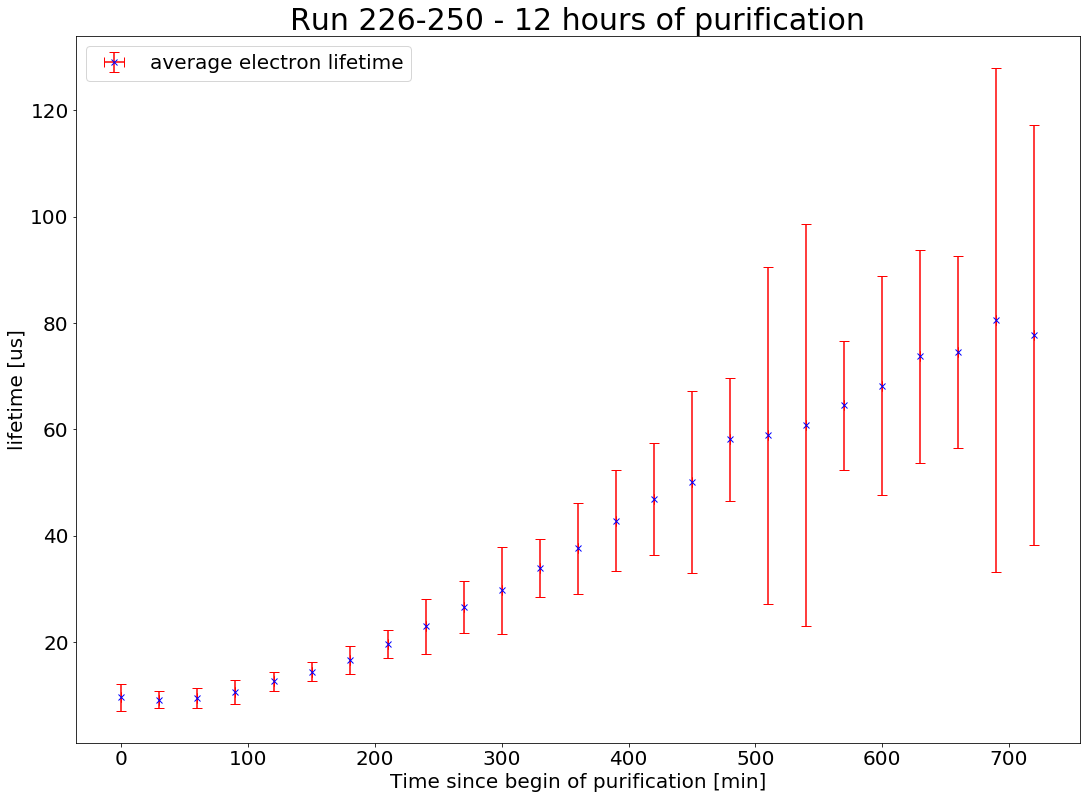

In [232]:
def expo(x, a, b):
    return a*np.exp(-b*x)

fig, ax =plt.subplots(figsize = (18,13))
#p0=  [10000,0.1]


SIZE = 20
EXTRA_SIZE = 30

plt.rc('font', size=SIZE)          # controls default text sizes
plt.rc('axes', titlesize=EXTRA_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SIZE)    # legend fontsize
plt.rc('figure', titlesize=SIZE)

#popt, pcov = curve_fit(expo, x, y_values, sigma=y_error, p0=p0, absolute_sigma=True, maxfev= 10000)
# lifetime = 1/popt[1]
# lifetime_error = (1/(popt[1]**2))*perr[1]
#lifetime = "%.2f" % (1/popt[1]*np.log(2))
#lifetime_error = "%.2f" % ((1/(popt[1]**2))*perr[1])

plt.errorbar(Time, Electron_lifetime_list, yerr=Electron_lifetime_error_list, xerr=0, ecolor='red', capsize=5, fmt = 'bx', label = 'average electron lifetime' )

print('this is lamba: ', popt[1])
print('this is 1/lamba: ', 1/popt[1] )
#plt.plot(x, expo(x, *popt), 'g--', label = 'electron lifetime = '+str(lifetime)+ ' +/- '+str(lifetime_error)+' us')
# print(y_error)


#ax.set_ylim([130,250])
ax.set_title('Run 226-250 - 12 hours of purification')
ax.set_xlabel('Time since begin of purification [min]')
ax.set_ylabel('lifetime [us]')


#print('electron lifetime: ', lifetime, '+/-', lifetime_error)
# print(perr)
plt.legend(prop={'size': 20})
plt.show()